In [ ]:

import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
import config as global_config
import os

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Working on Google streetview images
In this notebook, we are going to show the proof of concept of the idea: Compensated Foreground Object removal using Multiview Images

## Segmentation using mask RCNN

In [5]:
IMAGES_FILEPATH_DIR = global_config.IMAGES_FILEPATH_DIR
IMAGES_FILEPATH_PARENT_DIR = global_config.IMAGES_FILEPATH_PARENT_DIR
MODEL_OUTPUTS_PATH = global_config.MODEL_OUTPUTS_PATH
MODEL_MASKS_IMGS_PATH = global_config.MODEL_MASKS_IMGS_PATH
# os.listdir(IMAGES_FILEPATH_PARENT_DIR)

['original_images']

In [6]:
image_filenames = sorted(os.listdir(IMAGES_FILEPATH_DIR))
print(image_filenames)

['README.md']


In [ ]:
transform = T.Compose([
    T.ToTensor(), T.Resize((512, 1024))  ])
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(IMAGES_FILEPATH_PARENT_DIR,
                                                   transform= transform), # 
    batch_size  = 64,
    shuffle     = False,
)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


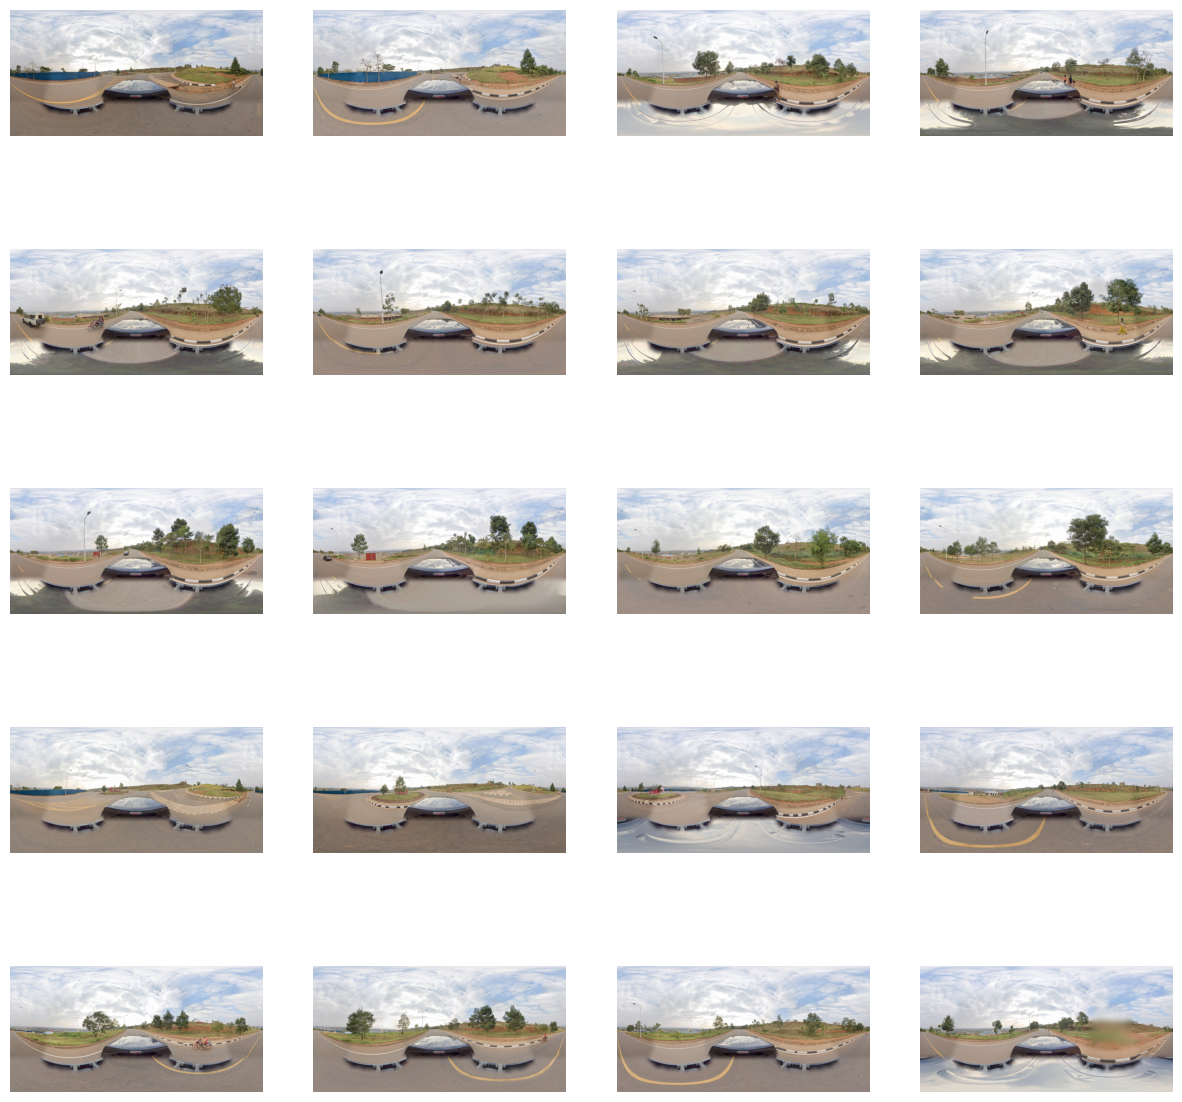

In [ ]:
r, c    = [5, 4]
fig, ax = plt.subplots(r, c, figsize= (15, 15))
k       = 0
for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

In [ ]:
y.shape

torch.Size([20])

In [ ]:
# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()
global_preds = None
global_preds_info = None

# Make prediction
with torch.no_grad():
  for data in dtl:
      x, y = data
      # Extract masks with a high enough score
      prediction = model(x)



In [ ]:
for pred_idx in range(len(prediction)):
  classes_indexes = (prediction[pred_idx]['labels'] == 1).nonzero(as_tuple=False).flatten()
  if classes_indexes.shape[0] == 0:
    print(image_filenames[pred_idx])
    continue
  final_mask = False
  for i in classes_indexes:
    final_mask += ((prediction[pred_idx]['masks'][i].squeeze(dim=0)) > 0.5)
  final_mask = ~final_mask
  final_mask == -1
  # Upsample the final_mask by a factor of 4
  upsampled_final_mask = cv2.resize(final_mask.cpu().numpy().astype('uint8')*255, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
  output_path = f"{MODEL_MASKS_IMGS_PATH}{image_filenames[pred_idx]}"
  cv2.imwrite(output_path, upsampled_final_mask)

17.jpg
19.jpg
3.jpg


In [ ]:
upsampled_final_mask.shape

(2048, 4096)

In [ ]:
torch.save(prediction, f"{global_config.MODEL_OUTPUTS_PATH}20.pth")

In [ ]:
torch.load( f"{global_config.MODEL_OUTPUTS_PATH}20.pth")

[{'boxes': tensor([[ 898.9519,  281.4124,  913.9982,  323.9725],
          [ 368.6445,  275.1814,  653.8467,  365.4026],
          [  25.1313,  185.5899,  406.1976,  401.9149],
          [ 614.5035,  223.8291,  949.0981,  403.6810],
          [ 372.9442,  271.3895,  651.5645,  364.4256],
          [ 399.8587,  242.9008,  854.7881,  382.8712],
          [ 939.6117,  297.3252,  948.0357,  309.9487],
          [ 296.5479,  167.9112,  996.0764,  394.0038],
          [ 938.3650,  299.5883,  945.3344,  309.4668],
          [ 898.9715,  317.4267,  910.6656,  324.3450],
          [ 949.6389,  291.5292,  954.5798,  300.2083],
          [ 924.6188,  308.0221,  936.2533,  317.8448],
          [ 948.0267,  289.8626,  955.1893,  303.8505],
          [ 659.7243,  364.3407,  898.2567,  419.1372],
          [ 949.9530,  288.9278,  956.7816,  300.0655],
          [ 432.7162,  246.6960,  512.0443,  265.5743],
          [ 925.2847,  297.7225,  949.3783,  317.7307],
          [ 940.8846,  293.8636,  950.8